<a href="https://colab.research.google.com/github/thamsuppp/MusicGenDL/blob/main/Multi_Instrument_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Instrument RNN

In [ ]:
import os
import shutil
import glob
import numpy as np 
import pandas as pd
import pretty_midi
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import random
import itertools
root_dir = 'drive/MyDrive/CIS522 Project'
data_dir = root_dir + '/Lakh Piano Dataset/LPD-5/lpd_5/lpd_5_cleansed'
music_dataset_lpd_dir = root_dir + '/Music Dataset/midis/lmd_matched'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6MB 11.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 


**Getting MIDI and Song Metadata**

In [ ]:
RESULTS_PATH = os.path.join(root_dir, 'Lakh Piano Dataset', 'Metadata')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

# Load the midi npz file from the LMD cleansed folder
def get_midi_npz_path(msd_id, midi_md5):
    return os.path.join(data_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.npz')
    
# Load the midi file from the Music Dataset folder
def get_midi_path(msd_id, midi_md5):
    return os.path.join(music_dataset_lpd_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [ ]:
# Open the cleansed ids - cleansed file ids : msd ids
cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)
lpd_to_msd_ids = {a:b for a, b in zip(cleansed_ids[0], cleansed_ids[1])}
msd_to_lpd_ids = {a:b for a, b in zip(cleansed_ids[1], cleansed_ids[0])}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
# Reading the genre annotations
genre_file_dir = os.path.join(root_dir, 'Lakh Piano Dataset', 'Genre', 'msd_tagtraum_cd1.cls')
ids = []
genres = []
with open(genre_file_dir) as f:
    line = f.readline()
    while line:
        if line[0] != '#':
          split = line.strip().split("\t")
          if len(split) == 2:
            ids.append(split[0])
            genres.append(split[1])
          elif len(split) == 3:
            ids.append(split[0])
            ids.append(split[0])
            genres.append(split[1])
            genres.append(split[2])
        line = f.readline()
genre_df = pd.DataFrame(data={"TrackID": ids, "Genre": genres})

genre_dict = genre_df.groupby('TrackID')['Genre'].apply(lambda x: x.tolist()).to_dict()

**Objects that we need**

- cleansed_ids: dictionary of LPD file name : MSD file name
- lmd_metadata: list of dictionaries - each dict has a msd_id field to identify
- Get the lmd_file_name (actual path )

In [ ]:
# Load the processed metadata
with open(os.path.join(root_dir, 'Lakh Piano Dataset', 'processed_metadata.json'), 'r') as outfile:
  lmd_metadata = json.load(outfile)

# Change this into a dictionary of MSD_ID: metadata
lmd_metadata = {e['msd_id']:e for e in lmd_metadata}

In [ ]:
# Get all song MSD IDs in pop rock genre
rock_song_msd_ids = [k for k, v in lmd_metadata.items() if 'rock' in v['artist_terms']]

# Randomly choose 1000 songs out of these
#train_ids = random.choices(rock_song_msd_ids, k = 2000)

In [ ]:
rock_song_msd_ids = sorted(rock_song_msd_ids)

In [ ]:
combined_pianorolls = []
i = 0
for msd_file_name in rock_song_msd_ids[5000:]:

  lpd_file_name = msd_to_lpd_ids[msd_file_name]
  # Get the NPZ path
  npz_path = get_midi_npz_path(msd_file_name, lpd_file_name)
  multitrack = pypianoroll.load(npz_path)
  multitrack.set_resolution(2).pad_to_same()

  # Piano, Guitar, Bass, Strings, Drums
  # Splitting into different parts

  parts = {'piano_part': None, 'guitar_part': None, 'bass_part': None, 'strings_part': None, 'drums_part': None}
  song_length = None
  empty_array = None
  has_empty_parts = False
  for track in multitrack.tracks:
    if track.name == 'Drums':
      parts['drums_part'] = track.pianoroll
    if track.name == 'Piano':
      parts['piano_part'] = track.pianoroll
    if track.name == 'Guitar':
      parts['guitar_part'] = track.pianoroll
    if track.name == 'Bass':
      parts['bass_part'] = track.pianoroll
    if track.name == 'Strings':
      parts['strings_part'] = track.pianoroll
    if track.pianoroll.shape[0] > 0:
      empty_array = np.zeros_like(track.pianoroll)

  for k,v in parts.items():
    if v.shape[0] == 0:
      parts[k] = empty_array.copy()
      has_empty_parts = True

  # Stack all together - Piano, Guitar, Bass, Strings, Drums
  combined_pianoroll = torch.tensor([parts['piano_part'], parts['guitar_part'], parts['bass_part'], parts['strings_part'], parts['drums_part']])

  # These contain velocity information - the force with which the notes are hit - which can be standardized to 0/1 if we want (to compress)
  if has_empty_parts == False:
    combined_pianorolls.append(combined_pianoroll)
  i+=1

  if (i+1) % 100 == 0:
    print(i, datetime.now())

  if (i+1) % 1000 == 0:
    pianoroll_lengths = [e.size()[1] for e in combined_pianorolls]
    out = torch.hstack(combined_pianorolls)
    torch.save(out, os.path.join(root_dir, 'Lakh Piano Dataset', 'rock_pianorolls_res2_part1.pt'))
    pianoroll_lengths = torch.tensor(pianoroll_lengths)
    torch.save(pianoroll_lengths, os.path.join(root_dir, 'Lakh Piano Dataset', 'rock_pianorolls_lengths_res2_part1.pt'))
    del out
    print('Saved')

In [ ]:
pianoroll_lengths = [e.size()[1] for e in combined_pianorolls]
combined_pianorolls = torch.hstack(combined_pianorolls)

In [ ]:
torch.save(combined_pianorolls, os.path.join(root_dir, 'Lakh Piano Dataset', 'metal_1000_pianorolls.pt'))
pianoroll_lengths = torch.tensor(pianoroll_lengths)
torch.save(pianoroll_lengths, os.path.join(root_dir, 'Lakh Piano Dataset', 'metal_1000_pianorolls_lengths.pt'))

In [ ]:
# Loading
combined_pianorolls = torch.load(os.path.join(root_dir, 'Lakh Piano Dataset', 'rock_1000_pianorolls.pt'))
pianoroll_lengths = torch.load(os.path.join(root_dir, 'Lakh Piano Dataset', 'rock_1000_pianorolls_lengths.pt'))
pianoroll_lengths = pianoroll_lengths.numpy()
pianoroll_cum_lengths = pianoroll_lengths.cumsum()

In [ ]:
# Normalize
combined_pianorolls = combined_pianorolls / 127.0

### Getting the number of notes played in that time step
# Number of notes per time step per track
notes_per_time_step = (combined_pianorolls > 0).type(torch.float32).sum(axis = 2)
# Censor those with more than 10 notes to be 10
notes_per_time_step[notes_per_time_step > 10] = 10
# Normalize to be between [0, 4] - very important to get right
notes_per_time_step = notes_per_time_step / 2
notes_per_time_step = notes_per_time_step.unsqueeze(2)
# Concatenate the number vector
combined_pianorolls = torch.cat((combined_pianorolls, notes_per_time_step), dim = 2)

# Remake the list of pianorolls
pianorolls_list = []
pianorolls_list.append(combined_pianorolls[:, :pianoroll_cum_lengths[0], :])
for i in range(len(pianoroll_cum_lengths) - 1):
  pianoroll = combined_pianorolls[:, pianoroll_cum_lengths[i]:pianoroll_cum_lengths[i+1], :]
  pianoroll = pianoroll[:, ::2, :]
  pianorolls_list.append(pianoroll)

**Creating Music Dataset**

In [ ]:
# Creating dataset and dataloader
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MusicDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier

    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):

    # Choose a random song id
    song_id = random.randint(0, self.n_songs - 1)
    song_length = self.data[song_id].size()[1]

    # Choose a random start window
    start_time = random.randint(0, song_length - self.seq_length - 2)
    train_sequence = self.data[song_id][:, start_time:(start_time + self.seq_length), :]
    #target_sequence = self.data[song_id][:, (start_time + 1):(start_time + self.seq_length + 1), :]

    # Target is the next note
    target_sequence = self.data[song_id][:, (start_time + self.seq_length + 1), :]
    #print(song_id, start_time)
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

**RNN Generation Code**

In [ ]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
model = MultitrackGenerationRNN(input_size = 645, hidden_size = 100, output_size = 645, n_layers = 1).to(device)
hidden = model.init_hidden(batch_size = 32)
output, hidden = model(train.to(device), hidden)

In [ ]:
class MultitrackGenerationRNN(nn.Module):
  # input_size: number of possible pitches
  # hidden_size: embedding size of each pitch
  # output_size: number of possible pitches (probability distribution)
    def __init__(self, input_size, hidden_size, output_size, batch_size = 32, n_layers=1):
        super(MultitrackGenerationRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        # input_size: tracks x pitches
        # hidden_size: whatever we want
        #self.embedding = nn.Embedding(input_size, hidden_size)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size * n_layers, output_size)
    
    def forward(self, input, hidden):

        # Input: batch_size x n_tracks x seq_length x pitches
        input = input.permute(0,2,1,3)
        # batch x seq_length x track x pitches
        input = input.flatten(2,3) # Flatten the track and pitches together
        # batch x seq_length x (track x pitches)
        # input = self.embedding(input)
        # # batch x seq_length x hidden_dim
        input = input.permute(1,0,2)
        # seq length x batch x hidden_dim
        _, hidden = self.gru(input, hidden)

        # Hidden: hidden layer at FINAL state
        # hidden dim: (num_layer x num_dir) x batch x hidden_size
        # **Difference between GRU and LSTMs
        h_n = hidden.permute(1,0,2)
        # h_n is batch x (num_layer x num_dir) x hidden_size
        h_n = h_n.contiguous().flatten(1,2)
        # After flattening: batch x (num_layer x num_dir x hidden_size)
        output = self.linear(h_n)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

In [ ]:
def train_epoch(dataloader, model, optimizer, criterion):
  
    running_loss = 0
    n_obs = 0
    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for train_seq, target_seq in dataloader:
      train_seq = train_seq.to(device)
      target_seq = target_seq.to(device)
      hidden = model.init_hidden(batch_size = 32)
      optimizer.zero_grad()
      target_seq = target_seq.flatten(1,2)
      output, hidden = model(train_seq, hidden)
      loss = criterion(output, target_seq)
      # Backpropagate, clip gradient and optimize
      loss.backward()
      grad_clipping(model, 1)
      optimizer.step()

      running_loss += loss.item()
      n_obs += train_seq.size()[0]

    # Return average loss for the input sequence
    return running_loss / n_obs * 100

def test_epoch(dataloader, model, optimizer, criterion):
    
    running_loss = 0
    n_obs = 0
    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for train_seq, target_seq in dataloader:
      train_seq = train_seq.to(device)
      target_seq = target_seq.to(device)
      hidden = model.init_hidden(batch_size = 32)
      target_seq = target_seq.flatten(1,2)
      optimizer.zero_grad()

      output, hidden = model(train_seq, hidden)
      loss = criterion(output, target_seq)
      running_loss += loss.item()
      n_obs += train_seq.size()[0]

    # Return average loss for the input sequence
    return running_loss / n_obs * 100

In [ ]:
# Overall training loop
def training_loop(model, optimizer, scheduler, criterion, train_dataloader, test_dataloader):

  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    model.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = train_epoch(train_dataloader, model, optimizer, criterion)
    train_losses.append(train_epoch_loss)
    scheduler.step()

    model.eval()
    test_epoch_loss = test_epoch(test_dataloader, model, optimizer, criterion)
    test_losses.append(test_epoch_loss)

    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))

  return train_losses, test_losses

In [ ]:
experiment_params = {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 3, 'LR_LAMBDA': 0.98}

train_dataset = MusicDataset(pianorolls_list[0:900], dataset_length = 32 * 1000, seq_length = experiment_params['SEQ_LENGTH'])
train_loader = DataLoader(train_dataset, batch_size = 32, 
                                    drop_last=True)
test_dataset = MusicDataset(pianorolls_list[900:1000], dataset_length = 32 * 500, seq_length = experiment_params['SEQ_LENGTH'])
test_loader = DataLoader(test_dataset, batch_size = 32, 
                                    drop_last=True)

[0.001]
Epoch 1, Train Loss: 0.021983244715374894, Test Loss: 0.021761149985832163, Time: 2021-04-26 23:01:20.718755
[0.001]
Epoch 2, Train Loss: 0.01928934058814775, Test Loss: 0.02088957944943104, Time: 2021-04-26 23:01:54.488649
[0.001]
Epoch 3, Train Loss: 0.018501894807559437, Test Loss: 0.02050555087334942, Time: 2021-04-26 23:02:28.274033
[0.001]
Epoch 4, Train Loss: 0.018281032826780574, Test Loss: 0.01998165672994219, Time: 2021-04-26 23:03:01.985690
[0.001]
Epoch 5, Train Loss: 0.017991261748829857, Test Loss: 0.020183460190310143, Time: 2021-04-26 23:03:35.739013
[0.001]
Epoch 6, Train Loss: 0.01760094254859723, Test Loss: 0.019565296242944896, Time: 2021-04-26 23:04:09.484870
[0.001]
Epoch 7, Train Loss: 0.01746042084414512, Test Loss: 0.019730493865790778, Time: 2021-04-26 23:04:43.225681
[0.001]
Epoch 8, Train Loss: 0.017129367795132567, Test Loss: 0.019628765317611395, Time: 2021-04-26 23:05:17.040135
[0.001]
Epoch 9, Train Loss: 0.017054186001041673, Test Loss: 0.019331

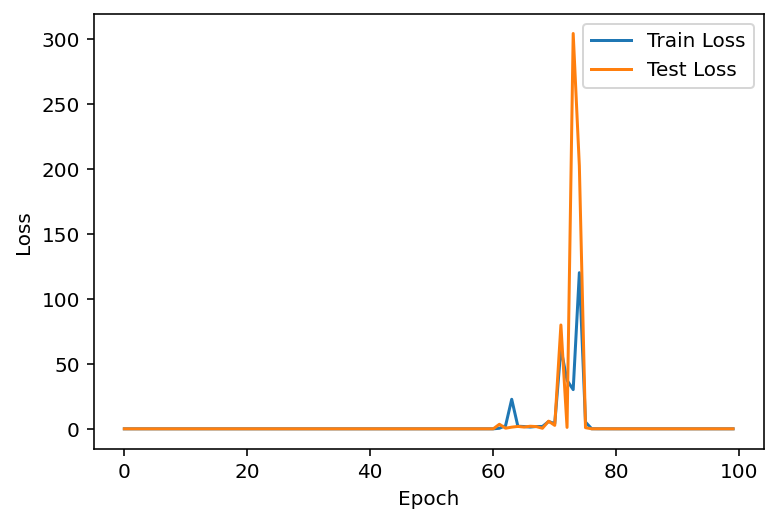

In [ ]:
# Running the training loop
experiment_params = {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 3, 'LR_LAMBDA': 1}

hidden_size = experiment_params['HIDDEN_SIZE']
n_layers = experiment_params['N_LAYERS']
n_epochs = 100
lr = 0.001
lr_lambda = experiment_params['LR_LAMBDA']

train_dataset = MusicDataset(pianorolls_list[0:900], dataset_length = 32 * 1000, seq_length = experiment_params['SEQ_LENGTH'])
train_loader = DataLoader(train_dataset, batch_size = 32, 
                                    drop_last=True)
test_dataset = MusicDataset(pianorolls_list[900:1000], dataset_length = 32 * 500, seq_length = experiment_params['SEQ_LENGTH'])
test_loader = DataLoader(test_dataset, batch_size = 32, 
                                    drop_last=True)

# Create model, optimizer and loss function
model = MultitrackGenerationRNN(input_size = 645, hidden_size = hidden_size, output_size = 645, n_layers = n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.MSELoss()
train_losses, test_losses = training_loop(model, optimizer, scheduler, criterion, train_loader, test_loader)

# Plot the losses over epochs
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
model_name = 'RNN with number 26 Apr 3'
save_path = os.path.join(root_dir, 'Saved Models', model_name)
torch.save(model.state_dict(), save_path)

1 {'SEQ_LENGTH': 200, 'HIDDEN_SIZE': 512, 'N_LAYERS': 5, 'LR_LAMBDA': 0.97}
[0.001]
Epoch 1, Train Loss: 0.01216346242799773, Test Loss: 0.0120774064125726, Time: 2021-04-22 14:09:11.135378
[0.0009699999999999999]
Epoch 2, Train Loss: 0.010748981499273214, Test Loss: 0.011657000446575694, Time: 2021-04-22 14:10:47.071486
[0.0009408999999999999]
Epoch 3, Train Loss: 0.010530379430565518, Test Loss: 0.011501896542904433, Time: 2021-04-22 14:12:22.816158
[0.000912673]
Epoch 4, Train Loss: 0.010239098324382212, Test Loss: 0.01123128965118667, Time: 2021-04-22 14:13:58.625117
[0.00088529281]
Epoch 5, Train Loss: 0.009979302562351222, Test Loss: 0.011141488763678353, Time: 2021-04-22 14:15:34.303386
[0.0008587340257]
Epoch 6, Train Loss: 0.009860353812837274, Test Loss: 0.011066198001208248, Time: 2021-04-22 14:17:09.664285
[0.0008329720049289998]
Epoch 7, Train Loss: 0.009762146770663093, Test Loss: 0.010868464123632293, Time: 2021-04-22 14:18:45.080025
[0.0008079828447811299]
Epoch 8, Trai

KeyboardInterrupt: ignored

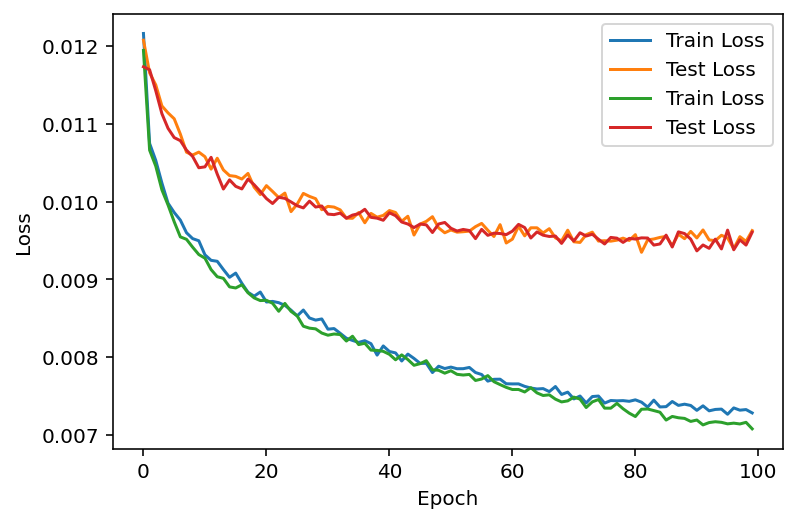

In [ ]:
# Hyperparameter tuning loop

#{'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 3, 'LR_LAMBDA': 0.98},
experiment_params_list = [
                     {'SEQ_LENGTH': 200, 'HIDDEN_SIZE': 512, 'N_LAYERS': 5, 'LR_LAMBDA': 0.97},
                     {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 4, 'LR_LAMBDA': 0.98},
                     {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 3, 'LR_LAMBDA': 0.96},
                     {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 512, 'N_LAYERS': 3, 'LR_LAMBDA': 0.99},
                     {'SEQ_LENGTH': 100, 'HIDDEN_SIZE': 256, 'N_LAYERS': 3, 'LR_LAMBDA': 0.98}]

experiment_num = 1
for experiment_params in experiment_params_list:                    

  print(experiment_num, experiment_params)
  hidden_size = experiment_params['HIDDEN_SIZE']
  n_layers = experiment_params['N_LAYERS']
  n_epochs = 100
  lr = 0.001
  lr_lambda = experiment_params['LR_LAMBDA']

  train_dataset = MusicDataset(combined_pianorolls[0:900], dataset_length = 32 * 1000, seq_length = experiment_params['SEQ_LENGTH'])
  train_loader = DataLoader(train_dataset, batch_size = 32, 
                                      drop_last=True)
  test_dataset = MusicDataset(combined_pianorolls[900:1000], dataset_length = 32 * 500, seq_length = experiment_params['SEQ_LENGTH'])
  test_loader = DataLoader(test_dataset, batch_size = 32, 
                                      drop_last=True)

  # Create model, optimizer and loss function
  model = MultitrackGenerationRNN(input_size = 640, hidden_size = hidden_size, output_size = 640, n_layers = n_layers).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
  criterion = nn.MSELoss()
  train_losses, test_losses = training_loop(model, optimizer, scheduler, criterion, train_loader, test_loader)

  # Plot the losses over epochs
  plt.plot(train_losses, label = 'Train Loss')
  plt.plot(test_losses, label = 'Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  model_name = 'RNN 21 Apr New Overnight exp{}'.format(experiment_num)
  save_path = os.path.join(root_dir, 'Saved Models', model_name)
  torch.save(model.state_dict(), save_path)
  experiment_num += 1

In [ ]:
experiment_num = 3
model_name = 'RNN 20 Apr New Overnight exp{}'.format(experiment_num)
save_path = os.path.join(root_dir, 'Saved Models', model_name)
torch.save(model.state_dict(), save_path)

**Loading Saved Model**

In [ ]:
hidden_size = 512
n_layers = 5

train_dataset = MusicDataset(combined_pianorolls[0:900], dataset_length = 32 * 1000, seq_length = 100)
train_loader = DataLoader(train_dataset, batch_size = 32, 
                                      drop_last=True)
model_name = 'RNN 21 Apr New Overnight exp1'
save_path = os.path.join(root_dir, 'Saved Models', model_name)
model = MultitrackGenerationRNN(input_size = 640, hidden_size = hidden_size, output_size = 640, n_layers = n_layers)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
train, target = next(iter(train_loader))

In [ ]:
hidden = model.init_hidden(batch_size = 32)
predicted, hidden = model(train.to(device), hidden)

predict_len = 200
temperature = 12

prime_seq = train[30, :, 20:30, :].to(device)
hidden = model.init_hidden(batch_size = 1)

# Instantiate new tensor to store predicted sequences: n_tracks x seq_length x pitches (128)
predictions = torch.zeros((5, predict_len + prime_seq.size()[1], 128)).to(device)

# Set the start of the predicted seq to be the prime sequence
predictions[:, 0:prime_seq.size()[1], :] = prime_seq[:, :, :128]
curr_predict_id = prime_seq.size()[1]

prime_seq = prime_seq.unsqueeze(0)

# Build up the hidden state
_, hidden = model(prime_seq, hidden)

# prime_seq is 1 x 5 x 50 x 129
input = prime_seq[:, :, -1:, :]
# input is 1 x 5 x 1 x 129

scores, hidden = model(input, hidden)
# predicted is 1 x 645
scores = scores.view(5, 129)
predicted_n_notes = (scores[:, -1] * 2 + 1).type(torch.int8)

print(predicted_n_notes)
scores = scores[:, :-1]

scores = scores / predicted.max()
predicted_probs = F.softmax(scores * temperature, dim = 1)
predicted = torch.zeros_like(scores)


tensor([4, 3, 2, 3, 1], device='cuda:0', dtype=torch.int8)


In [ ]:
i = 0
instrument_predicted_n_notes = predicted_n_notes[i].item()

In [ ]:
topk, indices = torch.topk(predicted_probs[i, :], instrument_predicted_n_notes * 2) # Twice the number of notes up for selection
instrument_predicted_indices_ids = torch.multinomial(topk, num_samples = instrument_predicted_n_notes)
instrument_predicted_ids = torch.gather(indices, 0, instrument_predicted_indices_ids)

In [ ]:

for i in range(5):
  instrument_predicted_n_notes = predicted_n_notes[i].item() #  Get number of predicted notes for that instrument
  if instrument_predicted_n_notes > 0:
    topk, indices = torch.topk(predicted_probs[i, :], instrument_predicted_n_notes * 2) # Twice the number of notes up for selection
    instrument_predicted_indices_ids = torch.multinomial(topk, num_samples = instrument_predicted_n_notes)
    instrument_predicted_ids = torch.gather(indices, 0, instrument_predicted_indices_ids)
    predicted[i, instrument_predicted_ids] = 1 # Set the predicted notes ids to 1

# Set next input to just generated prediction
input = predicted.clone()
# Get number of notes for generated prediction
new_predicted_n_notes = (predicted > 0).sum(axis = 1) / 10
new_predicted_n_notes = new_predicted_n_notes.unsqueeze(1)
input = torch.cat((input, new_predicted_n_notes), dim = 1)

predictions[:, curr_predict_id, :] = predicted

In [ ]:
# Code to evaluate the language model i.e. generate new music
# Old code that only generates a fixed number of notes per instrument at any time

def evaluate(net, prime_seq, predict_len = 100, temperature = 20):
    '''
    Arguments:
    prime_seq - priming sequence (converted t)
    predict_len - number of notes to predict for after prime sequence
    '''
    hidden = net.init_hidden(batch_size = 1)

    # Instantiate new tensor to store predicted sequences
    predictions = torch.zeros((5, predict_len + prime_seq.size()[1], 128)).to(device)

    # Set the start of the predicted seq to be the prime sequence
    predictions[:, 0:prime_seq.size()[1], :] = prime_seq[:, :, :128]

    curr_predict_id = prime_seq.size()[1]

    # Reshape prime seq 
    # from n_tracks x seq_length x pitches
    # to become batch_size x n_tracks x seq_length x pitches
    prime_seq = prime_seq.unsqueeze(0)

    # Build up the hidden state
    _, hidden = net(prime_seq, hidden)
    # Input is last character of prime sequence
    input = predictions[:, prime_seq.size()[1] - 1, :]

    while curr_predict_id < predictions.size()[1]:
      print('input before', input.size())
      # Forward pass of the trained NN - to get next predicted front
      input = input.unsqueeze(0).unsqueeze(2)
      print('input after', input.size())
      predicted, hidden = net(input, hidden)
      predicted = predicted / predicted.max()
      predicted = predicted.view(5, 128)

      predicted_probs = F.softmax(predicted * temperature, dim = 1)
      predicted_probs[predicted_probs < 0.001] = 0.0
      predicted_ids = torch.multinomial(predicted_probs, num_samples = 3)
      predicted = torch.zeros_like(predicted)

      for i in range(5):
        predicted[i, predicted_ids[i]] = 1

      # Bernoulli randomly generate based on the probabilities
      #predicted = torch.bernoulli(predicted)
      input = predicted.clone()
      predictions[:, curr_predict_id, :] = predicted
      
      curr_predict_id += 1

    return predictions

In [ ]:
# Code to evaluate the language model i.e. generate new music
# New code that takes in the encoding of how many notes at every time step

def evaluateWithNumber(net, prime_seq, predict_len = 100, temperature = 20):
    '''
    Arguments:
    prime_seq - priming sequence (converted t)
    predict_len - number of notes to predict for after prime sequence
    '''
    hidden = model.init_hidden(batch_size = 1)

    # Instantiate new tensor to store predicted sequences: n_tracks x seq_length x pitches (128)
    predictions = torch.zeros((5, predict_len + prime_seq.size()[1], 128)).to(device)
    predictions_n_notes = torch.zeros((5, predict_len + prime_seq.size()[1]))

    # Set the start of the predicted seq to be the prime sequence
    predictions[:, 0:prime_seq.size()[1], :] = prime_seq[:, :, :128]
    curr_predict_id = prime_seq.size()[1]

    prime_seq = prime_seq.unsqueeze(0)

    # Build up the hidden state
    _, hidden = model(prime_seq, hidden)

    # prime_seq is 1 x 5 x 50 x 129
    input = prime_seq[:, :, -1:, :]
    # input is 1 x 5 x 1 x 129

    while curr_predict_id < predictions.size()[1]:
      
      scores, hidden = model(input, hidden)
      # predicted is 1 x 645
      scores = scores.view(5, 129)
      predicted_n_notes = (scores[:, -1] * 2 + 1).type(torch.int8)
      scores = scores[:, :-1]

      scores = scores / scores.max()
      predicted_probs = F.softmax(scores * temperature, dim = 1)
      predicted_probs[predicted_probs < 0.001] = 0.0
      predicted = torch.zeros_like(scores)

      for i in range(5):
        instrument_predicted_n_notes = predicted_n_notes[i].item() #  Get number of predicted notes for that instrument
        if instrument_predicted_n_notes > 0:
          topk, indices = torch.topk(predicted_probs[i, :], instrument_predicted_n_notes * 2) # Twice the number of notes up for consideration (get the top and ignore the rest)
          topk[0] = topk[0] / 2
          print(topk / topk.sum())
          instrument_predicted_indices_ids = torch.multinomial(topk, num_samples = instrument_predicted_n_notes) # Choose from the multinomial 
          instrument_predicted_ids = torch.gather(indices, 0, instrument_predicted_indices_ids)
          predicted[i, instrument_predicted_ids] = 1 # Set the predicted notes ids to 1

      # Set next input to just generated prediction
      input = predicted.clone()
      # Get number of notes for generated prediction
      new_predicted_n_notes = (predicted > 0).sum(axis = 1) / 2
      predictions_n_notes[:, curr_predict_id] = new_predicted_n_notes
      new_predicted_n_notes = new_predicted_n_notes.unsqueeze(1)
      input = torch.cat((input, new_predicted_n_notes), dim = 1).unsqueeze(0).unsqueeze(2)
      predictions[:, curr_predict_id, :] = predicted

      curr_predict_id += 1

    return predictions, predictions_n_notes

In [ ]:
# Prime sequence
model.to(device)
prime_seq = train[14, :, 30:80, :].to(device)
predictions, predictions_n_notes = evaluateWithNumber(model, prime_seq, predict_len = 100, temperature = 10)
# Unnormalize
predictions = (predictions * 127).type(torch.int8)

tensor([0.4430, 0.5570], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.2591, 0.2522, 0.1621, 0.0902, 0.0705, 0.0643, 0.0254, 0.0220, 0.0190,
        0.0129, 0.0119, 0.0105], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.3762, 0.6238], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.4613, 0.1686, 0.1659, 0.1170, 0.0448, 0.0424], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([0.9691, 0.0108, 0.0100, 0.0081, 0.0020, 0.0000, 0.0000, 0.0000],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8780, 0.1220], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.6261, 0.1446, 0.1303, 0.0489, 0.0417, 0.0064, 0.0021, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.6016, 0.2447, 0.1094, 0.0444], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([0.3289, 0.5421, 0.0670, 0.0365, 0.0164, 0.0092], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([0.6634, 0.3366, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0',


In [ ]:
# Prime sequence
model.to(device)
prime_seq = train[29, :, 10:20, 0:128].to(device)
predictions = evaluate(model, prime_seq, predict_len = 200, temperature = 10)
# Unnormalize
predictions = (predictions * 127).type(torch.int8)

In [ ]:
prime_seq.size()

torch.Size([5, 50, 129])

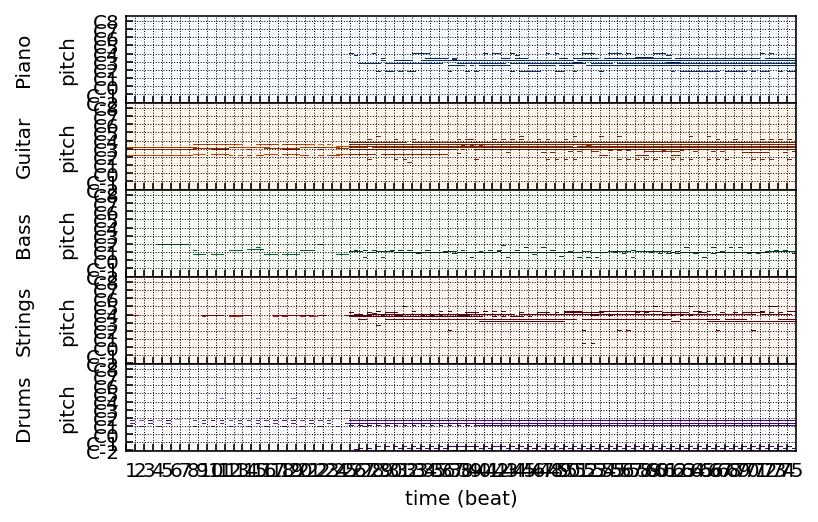

In [ ]:
# Convert predictions into the multitrack pianoroll
piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = predictions[0, :, :].detach().cpu().numpy())
guitar_track = pypianoroll.StandardTrack(name = 'Guitar', program = 24, is_drum = False, pianoroll = predictions[1, :, :].detach().cpu().numpy())
bass_track = pypianoroll.StandardTrack(name = 'Bass', program = 32, is_drum = False, pianoroll = predictions[2, :, :].detach().cpu().numpy())
strings_track = pypianoroll.StandardTrack(name = 'Strings', program = 48, is_drum = False, pianoroll = predictions[3, :, :].detach().cpu().numpy())
drums_track = pypianoroll.StandardTrack(name = 'Drums', is_drum = True, pianoroll = predictions[4, :, :].detach().cpu().numpy())


generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = [piano_track, guitar_track, bass_track, strings_track, drums_track])


#resolution=24, tempo=array(shape=(12000,), dtype=float64), downbeat=array(shape=(12000,), dtype=bool)
# Plot the generated multitrack
generated_multitrack.plot()

In [ ]:
# Convert generated multitrack to pretty midi
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)

In [ ]:
generated_path = os.path.join(root_dir, 'Generated MIDIs', 'multitrack_21apr_2.mid')
pypianoroll.write(generated_path, generated_multitrack)

In [ ]:
def evaluateMultinomial(net, prime_seq, predict_len, temperature=0.8):
    '''
    Arguments:
    prime_seq - priming sequence (converted t)
    predict_len - number of notes to predict for after prime sequence
    '''
    hidden = net.init_hidden()

    predicted = prime_seq.copy()
    prime_seq = torch.tensor(prime_seq, dtype = torch.long)


    # "Building up" the hidden state using the prime sequence
    for p in range(len(prime_seq) - 1):
        input = prime_seq[p]
        _, hidden = net(input, hidden)
    
    # Last character of prime sequence
    input = prime_seq[-1]
    
    # For every index to predict
    for p in range(predict_len):

        # Pass the inputs to the model - output has dimension n_pitches - scores for each of the possible characters
        output, hidden = net(input, hidden)
        # Sample from the network output as a multinomial distribution
        output = output.data.view(-1).div(temperature).exp()
        predicted_id = torch.multinomial(output, 1)

        # Add predicted index to the list and use as next input
        predicted.append(predicted_id.item()) 
        input = predicted_id

    return predicted

In [ ]:
generated_seq = evaluate(model, [100, 101, 102, 103, 104], predict_len = 100)
generated_seq_multinomial = evaluateMultinomial(model, [100, 101, 102, 103, 104], predict_len = 100, temperature = 1)
print(generated_seq)
print(generated_seq_multinomial)

[100, 101, 102, 103, 104, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391, 1227, 102, 1227, 391]
[100, 101, 102, 103, 104, 967, 813, 1204, 1088, 1167, 144, 1026, 1082, 1253, 541, 315, 1088, 460, 155, 190, 134, 633, 580, 214, 523, 493, 679, 638, 72, 833, 449, 214, 1038, 989, 813, 432, 626, 360, 129, 1235, 1180, 851, 1246, 1007, 1060, 1180, 605, 102, 179, 666, 102, 1196, 176, 827, 721, 268, 70, 1166, 1244, 1246, 1025, 316, 841, 682, 1186, 176, 318, 10, 852, 881, 50, 163, 573, 626, 761, 629, 644, 864, 1075, 864, 1020, 

**Converting Generated Sequences into MIDI/Audio**

In [ ]:
# Convert the generated ints into notes
generated_seq = [int_to_note[e] for e in generated_seq]
generated_seq_multinomial = [int_to_note[e] for e in generated_seq_multinomial]

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    return midi_stream

In [ ]:
generated_path = os.path.join(root_dir, 'Generated MIDIs', '19apr_2.mid')
generated_stream = create_midi(generated_seq_multinomial)
generated_stream.write('midi', fp=generated_path)

'drive/MyDrive/CIS522 Project/Generated MIDIs/19apr_2.mid'

In [ ]:
# Load the generated MIDI
generated_multitrack = pypianoroll.read(generated_path)
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)